# Creating your own classifier
## Introduction

As an additional bonus to the AllSorts Classifier I wish to create a little notebook to illustrate how one might make their own classifier.

*Why create your own classifier if AllSorts is so good?*

* All classifiers (AllSorts included) are only as good as the data they train on and their underlying compositions and biases.

* There are more sub-classes in Other which one may wish to train for in order to distinguish.

* Being able to create a classifier specific for samples extracted with your lab/university/hospitals technical biases should be more accurate than a general classifier.

* Its fun!

*What do I need to create my own classifier?*

* Lots of data with truth information, that is a label which indicates which class the samples should actually be defined as.

* A good composition of samples: A similar number of samples for each category which you desire to classify (such that you have a representative number of samples from which to construct the classifier from)

* Someone happy to read an implement python code and whom understands the data and its biases.

# Starting Point : Know your data

The beginnings of all data analysis journeys commence with looking at your data, understanding its strength and weaknesses and making sense of it.

Read in your data.

Caveat: For this notebook we will use a toy dataset of 195 samples simulated using [Splatter](https://github.com/Oshlack/splatter) where we have estimated the parameters of simulation from real data.

The simulated dataset can be found [here](https://github.com/Quarkins/Bioinformatics-Tidbits/tree/master/data).

In [1]:
#Read in libraries
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import pandas as pd
import math
from sklearn.cross_validation import train_test_split
import seaborn as sns

#Different Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

#Different Metrics/Plots
from sklearn.decomposition import PCA
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc

#For jupyter notebook to display figures
%matplotlib inline

In [2]:
#Read in the data
counts = pd.read_table("data/splat_counts.txt",sep="\t",header=0,index_col=0)
counts.head()
#counts.max(axis=1)

,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10,...,Sample_187,Sample_188,Sample_189,Sample_190,Sample_191,Sample_192,Sample_193,Sample_194,Sample_195,Length
Gene1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9017
Gene2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2827
Gene3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2533
Gene4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4390
Gene5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6340


In [3]:
#Read in the target info
targets = pd.read_table("data/splat_targets.txt",sep="\t",header=0,index_col=0)
targets.head()

,Group,LibSize
1,Group1,8.924882e+06
2,Group1,1.111405e+07
3,Group1,7.897770e+06
4,Group1,8.068987e+06
5,Group1,1.678402e+07


In [4]:
#Lets transform to FPKM
FPKM = counts.copy()
FPKM = FPKM.iloc[:,0:195]

#Divide by the LibSize every element in a column and x 1,000,000 to get 
#Fragments per kilobase per million

row =0
for index,col in FPKM.iteritems(): #Loop through columns (Samples)
    FPKM.loc[:,index] *1000000/targets.LibSize.iloc[row]
    row += 1
    
#Now lets log the data, log base 2 with an offset to avoid zero counts
def lb2(x):
    return math.log(x+0.25,2)

FPKM = FPKM.applymap(lb2)

FPKM.head()

,Sample_1,Sample_2,Sample_3,Sample_4,Sample_5,Sample_6,Sample_7,Sample_8,Sample_9,Sample_10,...,Sample_186,Sample_187,Sample_188,Sample_189,Sample_190,Sample_191,Sample_192,Sample_193,Sample_194,Sample_195
Gene1,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
Gene2,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
Gene3,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
Gene4,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
Gene5,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


In [5]:
#Now lets view what our data looks like in a PCA plot
transformed_counts = PCA(n_components=2).fit_transform(FPKM.transpose())

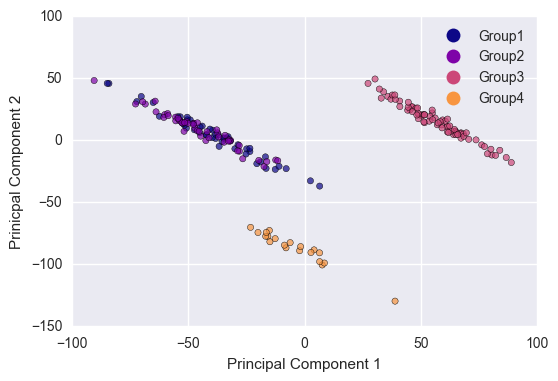

In [6]:
#Lets plot it!
#Get a color for each Class
cmap = plt.get_cmap('plasma')

def get_n_colors(n):
    return[ cmap(float(i)/n) for i in range(n)]

colors = get_n_colors(len(targets.Group.unique()))


#Make color dictionary
col_dict = {}     
for g in targets.Group.unique():
    col = colors[int(g.lstrip('Group'))-1]
    col = list(col)
    col[3] = 0.7 #Change alpha
    col_dict[g] = col

plt.scatter(transformed_counts[:,0],transformed_counts[:,1],c=targets.Group.apply(lambda x: col_dict[x]))

#Make custom handles for legend
circles = [Line2D(range(1),range(1),color='none',marker='o',markersize=10,markerfacecolor=col) for col in colors]
plt.legend(circles,targets.Group.unique())

plt.xlabel('Principal Component 1')
plt.ylabel('Prinicpal Component 2')

So clearly group 3 is very different from the other 3 and groups 1,2 and 4 cluster on top of each other which may be an issue, but let's see what these classifiers can do!

# Train Building

First we want to decide is how many (and which) of those thousands of gene we wish to use in our random forest model. The most agnostic approach is to use all genes, but this is computationally heavy and includes a lot of bloat. Since we have already seen that the different samples separate well by PC1 and PC2 it is probably fair to use the top 1000 most variable genes as these should contain most,if not all, of the biology.

In [7]:
#Transpose the dataset such that the rows are the observations and the columns the variables (Genes)
datExpr = FPKM.copy()
datExpr = datExpr.transpose()

#Find the most variable genes
sd_counts = datExpr.std(0)
sd_counts.sort_values(inplace=True,ascending=False)

#Subset just the top 1000 genes
datExpr = datExpr.loc[:,sd_counts.index.values[0:1000]]
datExpr.head()


,Gene39496,Gene19155,Gene17220,Gene31041,Gene32244,Gene5120,Gene16817,Gene9426,Gene40038,Gene19224,...,Gene7203,Gene24401,Gene25257,Gene18546,Gene24904,Gene28379,Gene376,Gene602,Gene12256,Gene28712
Sample_1,8.772315,13.695799,7.564149,13.592603,-2.000000,1.169925,7.695228,9.981924,17.925057,11.027388,...,4.189825,4.658211,8.072803,4.658211,1.169925,3.930737,6.823367,-2.000000,2.857981,5.651052
Sample_2,-2.000000,12.975355,-2.000000,2.392317,1.169925,13.005668,9.124768,8.611947,10.431759,7.533330,...,-2.000000,0.321928,5.531381,4.475733,9.638888,3.832890,9.224605,1.700440,5.888743,-2.000000
Sample_3,-2.000000,10.190133,12.926528,13.109871,-2.000000,13.467637,12.743414,15.238302,15.182171,13.709542,...,2.087463,6.005625,2.087463,7.828136,-2.000000,2.643856,4.475733,-2.000000,4.768184,6.252665
Sample_4,-2.000000,-2.000000,15.235089,12.000440,5.219169,6.344296,2.392317,2.643856,17.550651,4.539159,...,5.330917,3.491853,6.797662,3.357552,10.395802,4.918863,-2.000000,3.044394,3.614710,7.461479
Sample_5,14.377227,-2.000000,12.058753,8.225207,3.044394,11.163178,14.257627,11.942973,14.271116,-2.000000,...,4.266787,3.614710,7.984418,8.309476,8.267957,3.044394,5.982994,3.357552,3.614710,7.036174


In [8]:
#Shuffle and split training and test datasets
random_state= np.random.RandomState(0)
y=label_binarize(targets.Group,classes=targets.Group.unique())
X_train,X_test,y_train, y_test = train_test_split(datExpr,y,test_size=0.2,random_state=random_state)

In [9]:
#Learn to predict each class against the other
classifier = OneVsRestClassifier(LinearSVC(C=1))

y_score = classifier.fit(X_train,y_train).decision_function(X_test)

#Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(y.shape[1]):
    fpr[i],tpr[i], _ = roc_curve(y_test[:,i],y_score[:,i])
    roc_auc[i] = auc(fpr[i],tpr[i])


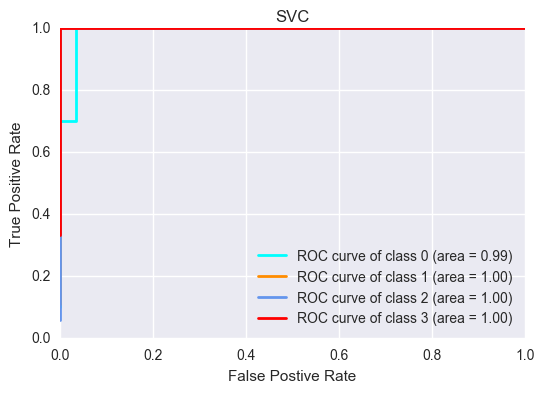

In [10]:
plt.figure()
colors = ['aqua','darkorange','cornflowerblue','red']

for i, color in zip(range(4),colors):
    plt.plot(fpr[i],tpr[i],color=color,lw=2,label = 'ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.legend(loc="lower right")
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC')

# Compare multiple calssification methods

In the above methodology we consider just one possible machine learning algorithm for classification, but with pythons scipy package we can easily just implement a whole host of different classification methods very quickly and view the ROC curve for different classes, lets implement this as a function.

In [11]:
#Lets define a function to classify the data with a given classifier

def class_and_plot(classifier,X_test,X_train,y_test,y_train,name):
    
    #Fit the classifier to the test data and train on the test data
    if(name != 'Random Forest'): 
        y_score = classifier.fit(X_train,y_train).decision_function(X_test)
    else: 
        y_score = classifier.fit(X_train,y_train).predict(X_test)
        
    #Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(y_test.shape[1]):
        fpr[i],tpr[i], _ = roc_curve(y_test[:,i],y_score[:,i])
        roc_auc[i] = auc(fpr[i],tpr[i])
        
    #Now plot
    plt.figure()
    colors = ['aqua','darkorange','cornflowerblue','red']

    for i, color in zip(range(4),colors):
        plt.plot(fpr[i],tpr[i],color=color,lw=2,label = 'ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    plt.legend(loc="lower right")
    plt.xlabel('False Postive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim((0,1))
    plt.title(name)
    
        

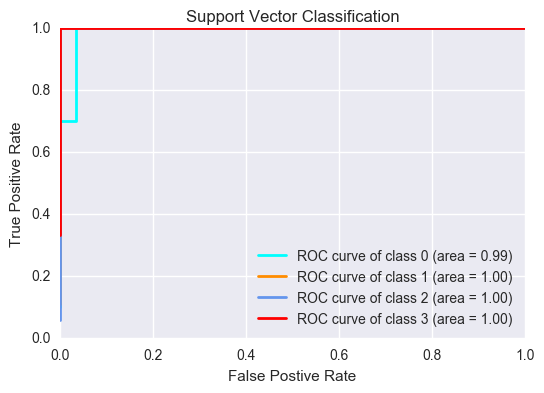

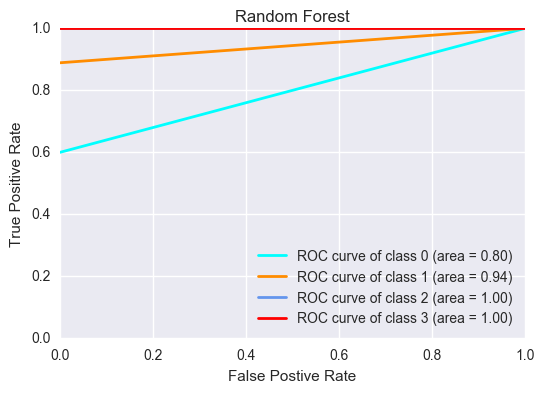

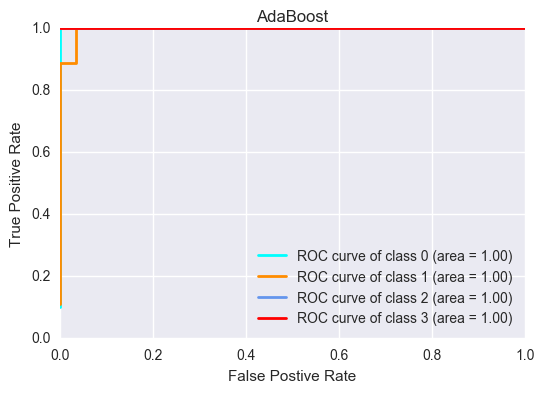

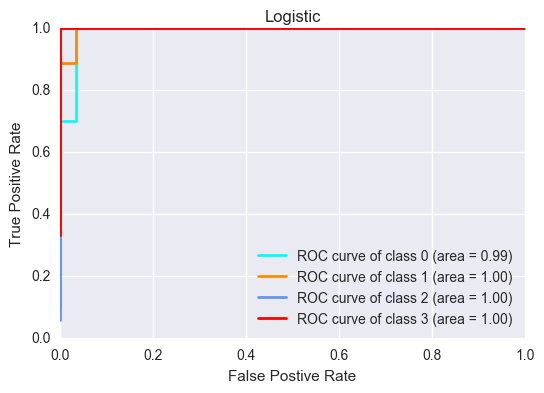

In [12]:
#Make a list containing all the classifiers you want to consider with the standard setup, note: for any specific 
#classifier you will want to refine and tweak the hyperparameters, however the defaults usually produce decent results
classifiers = [
    LinearSVC(C=1),
    RandomForestClassifier(n_estimators=501,),
    AdaBoostClassifier(),
    LogisticRegression()]

#Classifier names
cnames = ['Support Vector Classification','Random Forest', 'AdaBoost', 'Logistic']

for i,classifier in enumerate(classifiers):
    class_and_plot(OneVsRestClassifier(classifier),X_test,X_train,y_test,y_train,cnames[i])

# Choosing a classifer

Sometimes the choose of a classifier isnt simply down to which one performs best, but also whether the classification can result into meaningful results. In this simple toy dataset all four classifiers get near 100% accuracy and with the correct tuning of hyperparameters are more or less the same. However, with the random forest one can also recover the importance of the different genes used in creating the classifier which can be helpful when trying to gain some biological insight.

## But which genes are important?

So lets construct the random forest classifier and extract the important genes.





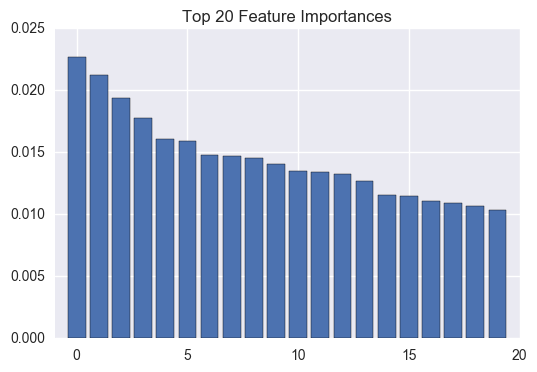

In [13]:
#Construct random forest
classifier = RandomForestClassifier(n_estimators=501)
forest = classifier.fit(X_train,y_train)

#Extract important features
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

#Plot
plt.figure()
plt.title("Top 20 Feature Importances")
plt.bar(range(20),importances[indices][:20],align="center")
plt.xlim(-1,20)

top20_names = X_test.columns.values[indices][:20]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

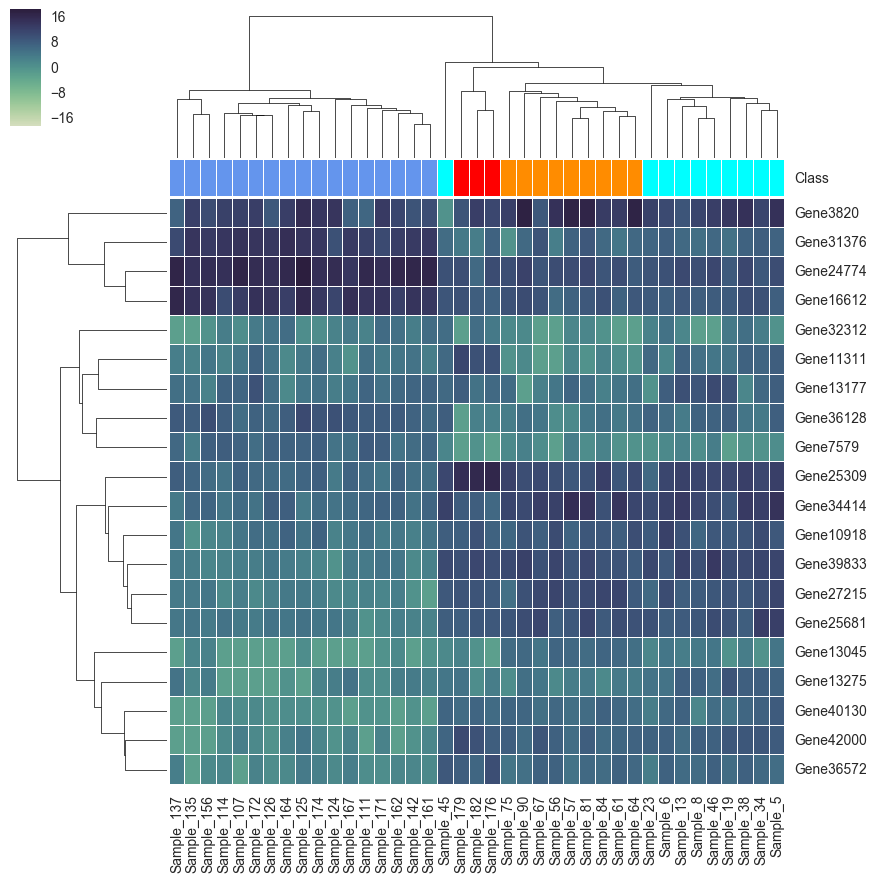

In [22]:
#Well lets make a hierarchical clustering of the top twenty genes
sub20 = X_test.loc[:,top20_names].transpose()

#Now uses sns hiearchical cluster map

# Create a custom colormap for the heatmap values
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)


#Convert classifer array to string
ttl = []
for arr in y_test:
    if(arr[0] == 1): 
        ttl.append('Group1')
    elif(arr[1]==1):
        ttl.append('Group2')
    elif(arr[2]==1):
        ttl.append('Group3')
    else:
        ttl.append('Group4')
        
class_pal = ['aqua','darkorange','cornflowerblue','red']       
class_dict = dict(zip(map(str, ['Group1','Group2','Group3','Group4']), class_pal))

# Convert the palette to vectors that will be drawn on the side of the matrix

sample_colors = pd.Series(ttl, index=sub20.columns.values,name="Class").map(class_dict)

cg = sns.clustermap(sub20, cmap=cmap ,linewidth=.01, col_colors=sample_colors)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
